<a href="https://colab.research.google.com/github/saketkc/pyFLGLM/blob/master/Chapters/03_Chapter03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3 - Normal Linear Models: Statistical Inference

In [ ]:
import warnings

import pandas as pd
import proplot as plot
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from scipy import stats

warnings.filterwarnings("ignore")
%pylab inline


plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

Populating the interactive namespace from numpy and matplotlib


In [ ]:
stats.f.ppf(0.95, 2, 27)  # 0.95 quantile of F dist. with df1=2, df2 =27

3.3541308285291986

In [ ]:
1 - stats.f.pdf(3.364131, 2, 27)  # right tail probability of non-central F

0.9602934531255635

In [ ]:
house_df = pd.read_csv("../data/Houses.tsv.gz", sep="\t")
house_df

,case,taxes,beds,baths,new,price,size
0,1,3104,4,2,0,279.9,2048
1,2,1173,2,1,0,146.5,912
2,3,3076,4,2,0,237.7,1654
3,4,1608,3,2,0,200.0,2068
4,5,1454,3,3,0,159.9,1477
...,...,...,...,...,...,...,...
95,96,990,2,2,0,176.0,1060
96,97,3030,3,2,0,196.5,1730
97,98,1580,3,2,0,132.2,1370
98,99,1770,3,2,0,88.4,1560


**Data Description**: Observations on recent homesales in Gainesville, Florida. 

In [ ]:
pd.concat([house_df.mean(), house_df.std()], axis=1).rename(
    columns={0: "mean", 1: "sd"}
)

,mean,sd
case,50.500,29.011492
taxes,1908.390,1235.825663
beds,3.000,0.651339
baths,1.960,0.567112
new,0.110,0.314466
price,155.331,101.262213
size,1629.280,666.941702


In [ ]:
fit = smf.ols(formula="""price ~ size + new""", data=house_df).fit()
print(fit.summary())
model_residuals = fit.resid
sd_model_residuals = model_residuals.std()
print("Residual SE: {}".format(np.round(sd_model_residuals, 2)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     126.3
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           9.79e-28
Time:                        23:41:14   Log-Likelihood:                -539.05
No. Observations:                 100   AIC:                             1084.
Df Residuals:                      97   BIC:                             1092.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -40.2309     14.696     -2.738      0.0

**Interpretation**: 
    
    - $H_0: \beta_1 = \beta_2 = 0$ The F-statistic with df1 = 2, df2 = 100-3 = 97 is  126.3 with a low p-value which is not surprising since the null is too strict. In some sense the probability of both the coefficients of size and new being 0 is low.
    
    - Coeff of new: Having "adjusted" for size the coefficient of new is still significant
    

95%CI for the mean selling price of new homes at the mean size of the new homes, 2354.73 square feet: 

In [ ]:
prediction = fit.get_prediction({"size": 2354.73, "new": 1})
prediction.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,290.963953,16.245718,258.720701,323.207205,179.270051,402.657856


**Interpretation**:  If the model truly holds, the 'mean_ci_lower' and 'mean_ci_upper' reflects
the 95% confidence interval where the population mean will lie. While 'obs_ci_lower' and 'obs_ci_upper' reflects the 95% CI where the future (predicted) will lie.    

# TODO: Derivation of the CI for mean and future y

Also see [CrossValidated](https://stats.stackexchange.com/questions/16493/difference-between-confidence-intervals-and-prediction-intervals/271232#271232)

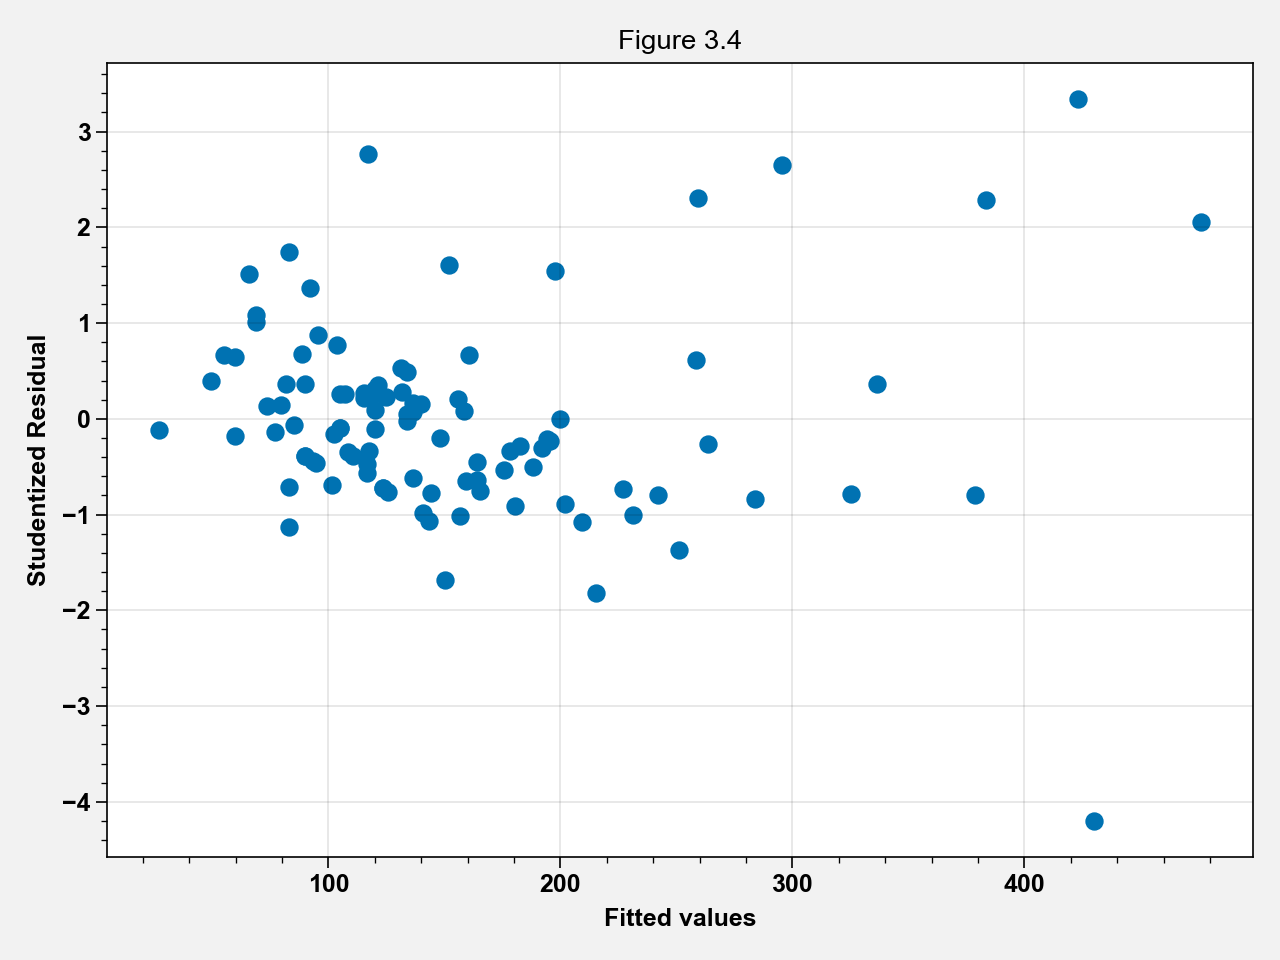

In [ ]:
fig, ax = plt.subplots()
ax.scatter(fit.fittedvalues, fit.get_influence().resid_studentized_internal)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Studentized Residual")
ax.set_title("Figure 3.4")
fig.tight_layout()

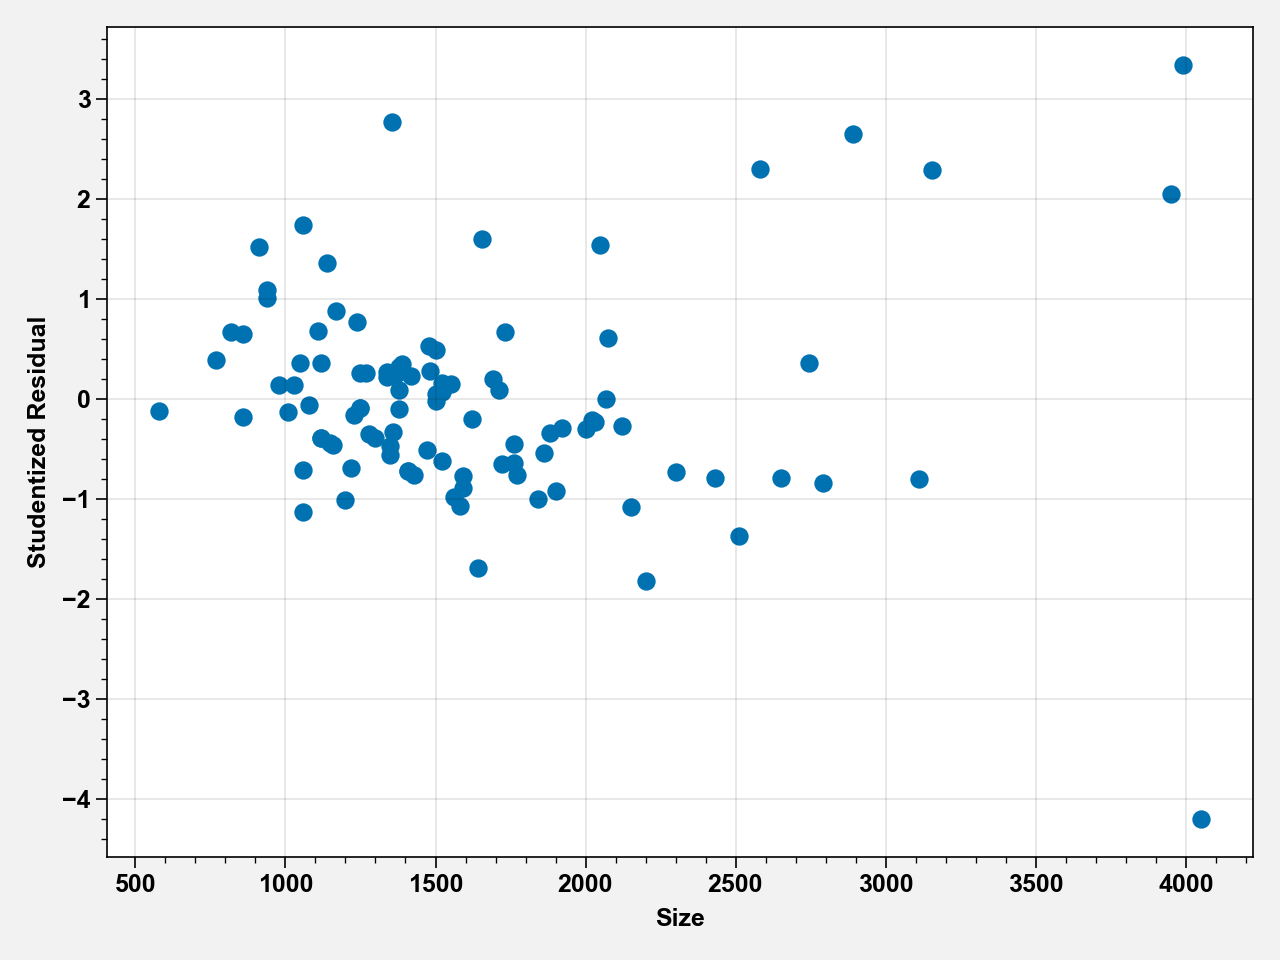

In [ ]:
fig, ax = plt.subplots()
ax.scatter(house_df["size"], fit.get_influence().resid_studentized_internal)
ax.set_xlabel("Size")
ax.set_ylabel("Studentized Residual")
fig.tight_layout()

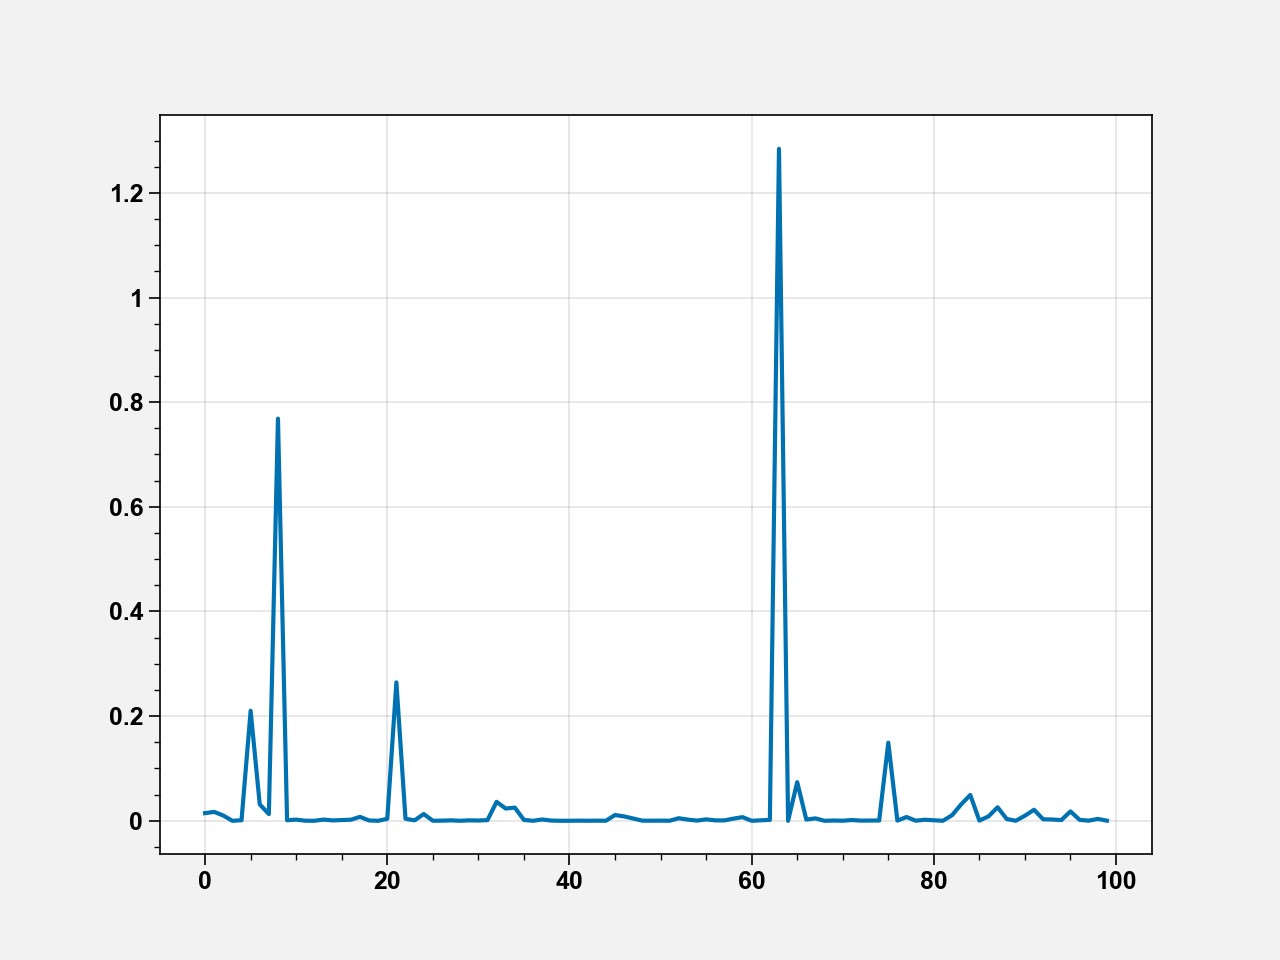

In [ ]:
cooks_distance = fit.get_influence().cooks_distance[0]
plt.plot(cooks_distance)

Observation 64 seems influential. Let's remove it and refit.

In [ ]:
fit = smf.ols(
    formula="""price ~ size + new""", data=house_df.loc[cooks_distance < 1]
).fit()
print(fit.summary())
model_residuals = fit.resid
sd_model_residuals = model_residuals.std()
print("Residual SE: {}".format(np.round(sd_model_residuals, 2)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     162.5
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           1.52e-31
Time:                        23:41:15   Log-Likelihood:                -524.21
No. Observations:                  99   AIC:                             1054.
Df Residuals:                      96   BIC:                             1062.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -63.1545     14.252     -4.431      0.0

$R^2$ sees a considerable improvement. Next we check for an interaction:


In [ ]:
fit = smf.ols(formula="""price ~ size + new + size:new""", data=house_df.loc[cooks_distance<1]).fit()
print(fit.summary())
model_residuals = fit.resid
sd_model_residuals = model_residuals.std()
print("Residual SE: {}".format(np.round(sd_model_residuals, 2)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     113.7
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           2.52e-31
Time:                        23:41:16   Log-Likelihood:                -521.95
No. Observations:                  99   AIC:                             1052.
Df Residuals:                      95   BIC:                             1062.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -48.2431     15.686     -3.075      0.0

The increase in $R^2$ is minimal.

# Simpson's paradox

Consider adding beds as another explanatory variable.




In [ ]:
stats.pearsonr(house_df['beds'], house_df['price'])

(0.3939570220583582, 5.006768706208471e-05)

Thus, beds is modestly correlated with price. Let's include it in the model and see how the fit changes.

In [ ]:
fit = smf.ols(formula="""price ~ size + new""", data=house_df).fit()
print(fit.summary())
model_residuals = fit.resid
sd_model_residuals = model_residuals.std()
print("Residual SE: {}".format(np.round(sd_model_residuals, 2)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     126.3
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           9.79e-28
Time:                        23:41:16   Log-Likelihood:                -539.05
No. Observations:                 100   AIC:                             1084.
Df Residuals:                      97   BIC:                             1092.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -40.2309     14.696     -2.738      0.0

In [ ]:
fit = smf.ols(formula="""price ~ size + new + beds""", data=house_df).fit()
print(fit.summary())
model_residuals = fit.resid
sd_model_residuals = model_residuals.std()
print("Residual SE: {}".format(np.round(sd_model_residuals, 2)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     83.97
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           9.68e-27
Time:                        23:41:16   Log-Likelihood:                -538.78
No. Observations:                 100   AIC:                             1086.
Df Residuals:                      96   BIC:                             1096.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.1998     25.602     -0.984      0.3

Including beds leads to a reduced $R^2$!! Thus, once `size` and `new` are in the model, it does not help to add beds. Although the marginal effect of beds is positive (as shown by the modest positive correlation), the estimated partial effect of beds is negative. This illustrates Simpson's paradox.

# Partial Correlation

In [ ]:
regress_sizenew_on_price = smf.ols(formula="""price ~ size + new""", data=house_df).fit()
regress_sizenew_on_bed = smf.ols(formula="""beds ~ size + new""", data=house_df).fit()

stats.pearsonr(regress_sizenew_on_price.resid, regress_sizenew_on_bed.resid)

(-0.07307200731424236, 0.4699872574144045)

Partial correlation between selling price and beds. Found using 1) finding the residuals for predicting selling price using size and new 2) finding the residual for predicting beds using size and new and 3) correlating the residuals in 1 and 2.

# TODO: Testing contrats as a general linear hypothesis

In [ ]:
from statsmodels.stats.libqsturng import psturng, qsturng

qsturng(0.95, 10, 190)

4.52786052558441

In [ ]:
stats.t.ppf(1-0.05/(2*45), 190)

3.3113791139604563